In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Flask Setup
from flask import Flask, jsonify
app = Flask(__name__)

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Create the inspector and connect it to the engine
from sqlalchemy import create_engine, inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Print column names/types within the 'measurment' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Print column names/types within the 'station' table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Get max measurement date

from sqlalchemy import desc
max_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

max_date = str(max_date[0])
max_date

'2017-08-23'

# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# Calculate the date 1 year ago from the last data point in the database

from datetime import datetime, timedelta

max_date_calc = datetime.strptime(max_date, "%Y-%m-%d") 
oneyearago = max_date_calc - timedelta(days=365)
print (max_date_calc, oneyearago) 

2017-08-23 00:00:00 2016-08-23 00:00:00


In [16]:
# Perform a query to retrieve the data and precipitation scores

last_yr_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= str(oneyearago)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

last_yr_precipitation

[('2016-08-24', 1.45),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.01),
 ('2016-08-27', None),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.05),
 ('2016-08-31', 2.46),
 ('2016-09-01', 0.01),
 ('2016-09-02', 0.03),
 ('2016-09-03', 1.0),
 ('2016-09-04', 0.44),
 ('2016-09-05', 0.18),
 ('2016-09-06', 1.0),
 ('2016-09-07', 1.35),
 ('2016-09-08', 0.15),
 ('2016-09-09', 0.35),
 ('2016-09-10', 1.16),
 ('2016-09-11', 0.6),
 ('2016-09-12', 1.04),
 ('2016-09-13', 1.2),
 ('2016-09-14', 6.7),
 ('2016-09-15', 3.35),
 ('2016-09-16', 0.61),
 ('2016-09-17', 0.23),
 ('2016-09-18', 0.42),
 ('2016-09-19', 0.25),
 ('2016-09-20', 0.43),
 ('2016-09-21', 1.02),
 ('2016-09-22', 0.75),
 ('2016-09-23', 0.33),
 ('2016-09-24', 0.27),
 ('2016-09-25', 0.04),
 ('2016-09-26', 1.02),
 ('2016-09-27', 1.0),
 ('2016-09-28', 0.05),
 ('2016-09-29', 1.49),
 ('2016-09-30', 0.38),
 ('2016-10-01', 1.02),
 ('2016-10-02', 0.61),
 ('2016-10-03', 0.46),
 ('2016-10-04', 3.46),
 ('2016-10-05', 0.81),
 ('2016-10-06', 0.

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

last_yr_precipitation_df = pd.DataFrame(last_yr_precipitation, columns=['date', 'precipitation'])
last_yr_precipitation_df.set_index('date', inplace=True)
last_yr_precipitation_df.dropna(inplace = True)
last_yr_precipitation_df.sort_values(by=['date'], ascending=True, inplace=True)

last_yr_precipitation_df.head()

,precipitation
date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-28,2.07
2016-08-29,0.90


<Figure size 576x432 with 0 Axes>

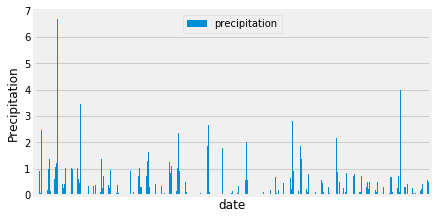

In [116]:
# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.pyplot import figure

figure(figsize=(8, 6))
last_yr_precipitation_df.plot.bar()
plt.legend(loc = 9)
plt.tight_layout()
plt.xticks([])
plt.ylabel('Precipitation')
plt.savefig('last_year_precipitation.png')
plt.show()



In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation = session.query(Measurement.date, Measurement.prcp).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

precipitation_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)
precipitation_df.dropna(inplace = True)

precipitation_df.describe()


,precipitation
count,2659.000000
mean,0.404735
std,0.696393
min,0.000000
25%,0.010000
50%,0.130000
75%,0.510000
max,8.060000


In [20]:
# Design a query to show how many stations are available in this dataset?
Stations = session.query(Station.id).count()

Stations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.id).label('count')).\
    group_by(Measurement.station).\
    order_by(desc('count')).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station.

sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

Stats = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()

Stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

last_yr_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= str(oneyearago), Measurement.station == "USC00519281").\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

last_year_temp_df = pd.DataFrame(last_yr_temp, columns=['date', 'tobs'])
last_year_temp_df.set_index('date', inplace=True)

last_year_temp_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


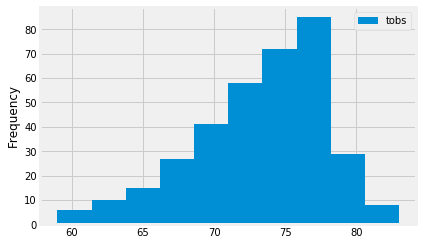

<Figure size 576x432 with 0 Axes>

In [24]:
# plot the results as a histogram

last_year_temp_df.plot.hist()
figure(figsize=(8, 6), facecolor='#f5f5f5')
plt.tight_layout()
plt.savefig('last_year_temp.png')
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps=[]
trip_temps=(calc_temps('2011-02-28', '2011-03-05'))

print (trip_temps)

trip_temp_df = pd.DataFrame(trip_temps, columns=['tmin', 'tave', 'tmax'])
trip_temp_df.head()

[(61.0, 69.75510204081633, 75.0)]


,tmin,tave,tmax
0,61.0,69.755102,75.0


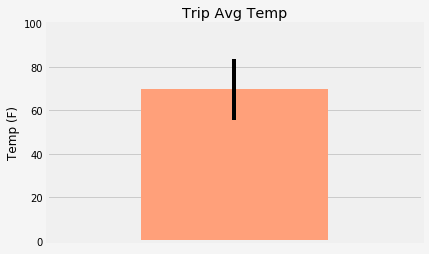

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

BAR_WIDTH = 1.0       

def main():
    figure(figsize=(6, 4), facecolor='whitesmoke')
    plt.title('Trip Avg Temp')
    categories = ['']
    values     = trip_temp_df.tave
    yerr_val = (trip_temp_df.tmax - trip_temp_df.tmin)
    # x-values for the center of each bar
    xs = np.arange(0, len(categories))
    # plot each bar centered
    plt.bar(xs + BAR_WIDTH/2, values, width=BAR_WIDTH/2, yerr=yerr_val, color="lightsalmon")
    # add bar labels
    plt.xticks(xs, categories)
    # make sure the chart is centered
    plt.xlim(0, len(categories))
    plt.ylabel('Temp (F)')
    plt.ylim(0,100)
    plt.savefig('trip_avg_temp.png')   
    plt.show()

main()


# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [28]:
# Create second function based on original provided to return statistics by station when station and dates are passed

def calc_rainfall(start_date, end_date, station):
    
    """
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        station: A text string identifying a valid station_id
        
    Returns:
        station, SUMPRCP for a list of dates
    """
    
    return session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).filter(Measurement.station == station).all()


In [38]:
# Get list of stations, pass to function and apppend results to list object

stations = session.query(Station.station).all()

stations_rainfall=[]

for station in stations:
    station_rainfall=calc_rainfall('2011-02-28', '2011-03-05', str(station[0]))
    stations_rainfall.append(station_rainfall)

stations_rainfall    
    
# Create dataframe from list (aggregated function return parameters) 
# then create another list object from dataframe that breaks aggregaged values into individual values
# finally reload dataframe from list to get  individual values and sort by descending percipitation

rainfall_df = pd.DataFrame(stations_rainfall, columns=['aggregate'])
stations_rainfall_list = rainfall_df['aggregate'].values.tolist()   
rainfall_df = pd.DataFrame(stations_rainfall_list, columns=['station','sumprcp'])

rainfall_df.sort_values(by='sumprcp', ascending = False, na_position='last', inplace = True)

rainfall_df.head(10)


,station,sumprcp
4,USC00518838,2.33
6,USC00519281,2.23
5,USC00519523,2.19
2,USC00514830,1.96
8,USC00516128,1.45
1,USC00513117,1.44
0,USC00519397,1.38
7,USC00511918,0.63
3,USC00517948,NaN


In [121]:
# List the station, name, latitude, longitude, and elevation with summary precipitation
# I couldn't join the precipitation information with the Station information after about a thousand tries using
#different approaches

output = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
order_by(Station.name).all()

#output = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,Rainfall.sumprcp).\
#.filter(Station.station == Rainfall.station).all()


[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

## Optional Challenge Assignment

In [130]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [129]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
